# Heating Analysis

##### A GWDST project to investigate heating distributions in space and time, along with investigations of variability

### Input and data

In [33]:
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from dask.distributed import Client

sns.set(context='talk', palette='colorblind')

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:60470 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 81.05 GB


In [3]:
ds = xr.open_mfdataset('/glade/scratch/mcamron/archive/f.c54120.FWscHIST.f09_f09.gwdst/atm/hist/f.c54120.FWscHIST.f09_f09.gwdst.cam.h1.2002-07-*.nc')
ds = ds.sel(lat=slice(-20,20))
ds

<xarray.Dataset>
Dimensions:          (ilev: 71, lat: 42, lev: 70, lon: 288, nbnd: 2, time: 744)
Coordinates:
  * lat              (lat) float64 -19.32 -18.38 -17.43 -16.49 -15.55 -14.61 ...
  * lon              (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 ...
  * lev              (lev) float64 5.96e-06 9.827e-06 1.62e-05 2.671e-05 ...
  * ilev             (ilev) float64 4.5e-06 7.42e-06 1.223e-05 2.017e-05 ...
  * time             (time) datetime64[ns] 2002-07-01 2002-07-01T00:59:59 ...
Dimensions without coordinates: nbnd
Data variables:
    gw               (time, lat) float64 0.01552 0.01561 0.01569 0.01577 ...
    hyam             (time, lev) float64 5.96e-09 9.827e-09 1.62e-08 ...
    hybm             (time, lev) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    P0               (time) float64 1e+05 1e+05 1e+05 1e+05 1e+05 1e+05 ...
    hyai             (time, ilev) float64 4.5e-09 7.42e-09 1.223e-08 ...
    hybi             (time, ilev) float64 0.0 0.0 0.0 0.0 0.0 0.

I need to define *cpair*, the specific heat of air in CESM, such to convert CLUBB/MG2 tendency fields to sensible heating. Below I will import and convert the ZM, CLUBB, and MG2 T tendencies and convert to relevant units, where ZMDT starts as *K / s* and CLUBB/MG2 start as *W / kg*. I will also separate out the precipitation fields to create altitude vs. rain-rate heating profiles.

In [4]:
cpair = 1004.64    # J / kg / K

In [5]:
zmdt = ds.ZMDT * 86400
cldt = ds.STEND_CLUBB / cpair * 86400
mgdt = ds.MPDT / cpair * 86400

pc = ds.PRECC * 3.6e6
pl = ds.PRECL * 3.6e6
pt = ds.PRECT * 3.6e6

## Distributions

##### 1-dimensional
*Very slow across 4-D hourly!*

In [6]:
print(zmdt.max().values, cldt.max().values, mgdt.max().values)
print(zmdt.min().values, cldt.min().values, mgdt.min().values)

123.87892976403236 195.7789622247219 119.0242487937212
-195.6308238208294 -157.59544372558594 -378.76249998807907


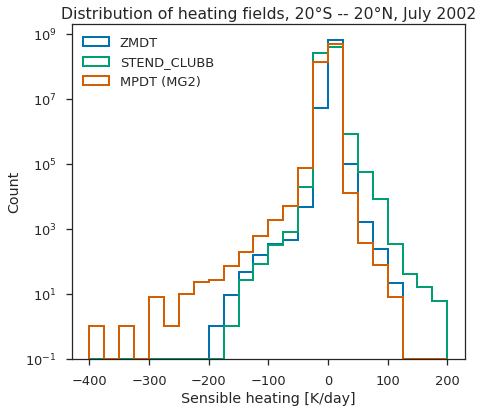

In [7]:
with sns.axes_style('ticks'):
    bins = np.arange(-400, 225, 25)    # from above
    f, ax = plt.subplots(figsize=(7,6))
    zmdt.plot.hist(ax=ax, bins=bins, log=True, histtype='step', linewidth=2, label='ZMDT')
    cldt.plot.hist(ax=ax, bins=bins, log=True, histtype='step', linewidth=2, label='STEND_CLUBB')
    mgdt.plot.hist(ax=ax, bins=bins, log=True, histtype='step', linewidth=2, label='MPDT (MG2)')

    ax.legend(loc='upper left')
    ax.set_xlabel('Sensible heating [K/day]')
    ax.set_title('Distribution of heating fields, 20' + u'\N{DEGREE SIGN}' + 'S -- 20' + u'\N{DEGREE SIGN}' + 'N, July 2002')

    plt.tight_layout()
    f.savefig('../figures/heating/dist_1D.png')

##### 2-dimension
To begin recreating rain-rate binned profiles of heating. Through exploration I discovered that my extrema could change drastically depending on rain-rate bin width.

In [89]:
ds.ZMDT.shape

(744, 70, 42, 288)

In [119]:
pc_bins = np.arange(0, ds.PRECC.max().values*3.6e6, 0.15)
test = (ds.ZMDT
    .groupby_bins(ds.PRECC*3.6e6, pc_bins, labels=pc_bins[1:], include_lowest=False)
    .mean(dim='stacked_time_lat_lon')
    .sel(lev=slice(100,1000)))
test = test*86400
test['lev'] = -7 * xu.log(test.lev / 1000)

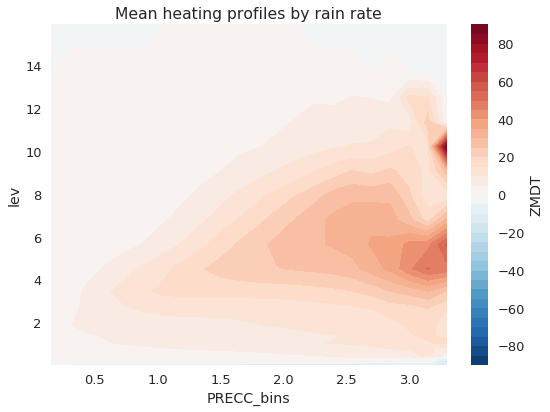

In [120]:
f, ax = plt.subplots(figsize=(8,6))
test.plot.contourf(ax=ax, levels=40)
ax.set_title('Mean heating profiles by rain rate')

plt.tight_layout()
f.savefig('../figures/heating/prof_zmdt-precc.png')